# Transfer Learning with TensorFlow Part 3: Scaling up (Food Vision Mini)


Goal: Beat the original food 101 paper with 10% of the training .
baseline to beat 50.76% accuracy across 101 classes

In [1]:
#Check to see if GPU is running
!nvidia-smi

Wed Jan 18 02:05:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper function



In [5]:
!wget https://raw.githubusercontent.com/krishnamenon215/Tensorflow/main/helper_functions.py

--2023-01-18 02:10:07--  https://raw.githubusercontent.com/krishnamenon215/Tensorflow/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-18 02:10:07 (84.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [6]:
#Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food classes: working with less data

Goal is to beat the original Food101 paper with 10% of training data

In [8]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2023-01-18 02:14:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G  23.6MB/s    in 67s     

2023-01-18 02:15:31 (23.0 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [9]:
train_dir ="101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [10]:
#how many images or classes are there
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/frozen_yogurt'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/club_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/escargots'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/onion_rings'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/strawberry_shortcake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/prime_rib'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spring_rolls'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pho'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beignets'.
There are 0 directories and 250 images in 

In [12]:
#setup data inputs
import tensorflow as tf
IMG_SIZE=(224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode = "categorical",
                                                                                image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) #dont shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps:
1. create modelcheckpoint callback
2. create data augmentation layer to build data augmentation right into the model
3. build a headless(no top layers) Functional EfficientNetB0 backboned-model
4. Compile model
5. Feature extraction to 5 full passes(5 epochs on train dataset and validate on 15% of the test data to save epoch time)

In [13]:
#Create checpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [16]:
#Create data augmentation layer to incoporate right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

#Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
    #preprocessing.Rescale(1/255.) required for ResNet models
], name = "data_augmentation")

In [18]:
#setup the base model and freee its layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3),name ="input_layer")
x = data_augmentation(inputs)
x = base_model(x,training= False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names),activation="softmax",name="output_layer")(x)
model = tf.keras.Model(inputs,outputs)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [21]:
# Compile
model.compile(loss = "categorical_crossentropy",
              optimizer= tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

#Fit
history_all_classes_10_percent= model.fit(train_data_all_10_percent,
                                          epochs=5,
                                          validation_data=test_data,
                                          validation_steps=int(0.15 *len(test_data)),
                                          callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 95s 340ms/step - loss: 3.3775 - accuracy: 0.2745 - val_loss: 2.4631 - val_accuracy: 0.4640
Epoch 2/5
237/237 [==============================] - 64s 267ms/step - loss: 2.2014 - accuracy: 0.4985 - val_loss: 2.0160 - val_accuracy: 0.5090
Epoch 3/5
237/237 [==============================] - 61s 255ms/step - loss: 1.8177 - accuracy: 0.5629 - val_loss: 1.9086 - val_accuracy: 0.5162
Epoch 4/5
237/237 [==============================] - 56s 234ms/step - loss: 1.6038 - accuracy: 0.6082 - val_loss: 1.8376 - val_accuracy: 0.5305
Epoch 5/5
237/237 [==============================] - 53s 221ms/step - loss: 1.4479 - accuracy: 0.6479 - val_loss: 1.7713 - val_accuracy: 0.5376


In [22]:
#Evaluate on whoel test data set
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 57s 73ms/step - loss: 1.5760 - accuracy: 0.5856


[1.5759682655334473, 0.5856237411499023]

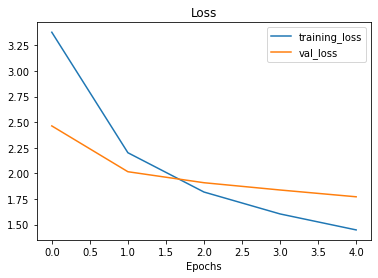

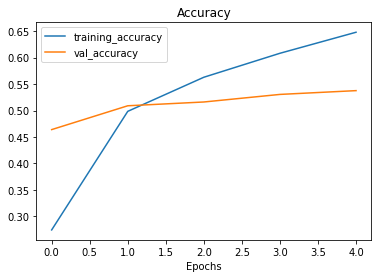

In [23]:
plot_loss_curves(history_all_classes_10_percent)

 ## Fine- tuning

In [24]:
#Unfreeze all of the layers in base model
base_model.trainable = True

#Refreeze every layer except last 5
for layer in base_model.layers[:-5]:
  layers.trainable = False

In [25]:
#Recompile model with lower learning rate
model.compile(loss="categorical_crossentropy",
              optimizer= tf.keras.optimizers.Adam(lr = 0.0001),
              metrics=["accuracy"])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [28]:
#what layers int he model are trainable
for layer in model.layers:
  print(layer.name,layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [29]:
#Check which layers are trainable in base_model
for layer_number,layer in enumerate(model.layers[2].layers):
  print(layer_number,layer.name,layer.trainable)

0 input_2 True
1 rescaling_1 True
2 normalization_1 True
3 tf.math.truediv_1 True
4 stem_conv_pad True
5 stem_conv True
6 stem_bn True
7 stem_activation True
8 block1a_dwconv True
9 block1a_bn True
10 block1a_activation True
11 block1a_se_squeeze True
12 block1a_se_reshape True
13 block1a_se_reduce True
14 block1a_se_expand True
15 block1a_se_excite True
16 block1a_project_conv True
17 block1a_project_bn True
18 block2a_expand_conv True
19 block2a_expand_bn True
20 block2a_expand_activation True
21 block2a_dwconv_pad True
22 block2a_dwconv True
23 block2a_bn True
24 block2a_activation True
25 block2a_se_squeeze True
26 block2a_se_reshape True
27 block2a_se_reduce True
28 block2a_se_expand True
29 block2a_se_excite True
30 block2a_project_conv True
31 block2a_project_bn True
32 block2b_expand_conv True
33 block2b_expand_bn True
34 block2b_expand_activation True
35 block2b_dwconv True
36 block2b_bn True
37 block2b_activation True
38 block2b_se_squeeze True
39 block2b_se_reshape True
40 b

In [32]:
#FIne tune for 5 more epochs
fine_tune_epochs = 10 #total no: of epochs (already done 5)

history_all_classes_10_percent_fine_tune =model.fit(train_data_all_10_percent,
                                                    epochs = fine_tune_epochs,
                                                    validation_data = test_data,
                                                    validation_steps = int(0.15 * len(test_data)),
                                                    initial_epoch = history_all_classes_10_percent.epoch[-1])
          

Epoch 5/10
237/237 [==============================] - 199s 796ms/step - loss: 1.1707 - accuracy: 0.6854 - val_loss: 1.6864 - val_accuracy: 0.5636
Epoch 6/10
237/237 [==============================] - 154s 645ms/step - loss: 0.8702 - accuracy: 0.7595 - val_loss: 1.5966 - val_accuracy: 0.5945
Epoch 7/10
237/237 [==============================] - 149s 627ms/step - loss: 0.6612 - accuracy: 0.8160 - val_loss: 1.7762 - val_accuracy: 0.5771
Epoch 8/10
237/237 [==============================] - 142s 597ms/step - loss: 0.5157 - accuracy: 0.8516 - val_loss: 1.7297 - val_accuracy: 0.5858
Epoch 9/10
237/237 [==============================] - 136s 572ms/step - loss: 0.3903 - accuracy: 0.8862 - val_loss: 1.9752 - val_accuracy: 0.5667
Epoch 10/10
237/237 [==============================] - 133s 557ms/step - loss: 0.2929 - accuracy: 0.9118 - val_loss: 2.1005 - val_accuracy: 0.5789


In [33]:
#Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 58s 74ms/step - loss: 1.7995 - accuracy: 0.6181


[1.7994717359542847, 0.61809903383255]

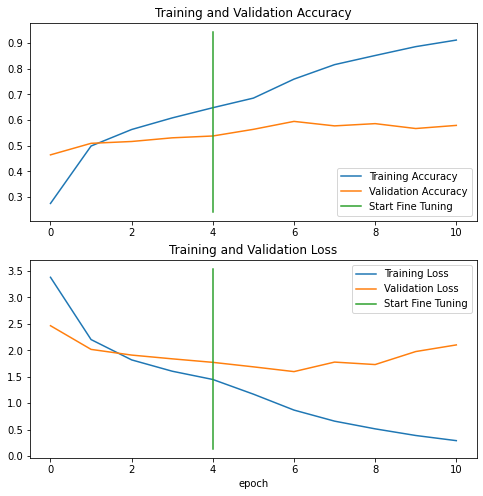

In [35]:
#Compare histories of feature extraction model with fine-tuning
compare_historys(history_all_classes_10_percent,history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

## Saving and loading our model


In [36]:
# Save our fine tuned model
model.save("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")

In [38]:
#Load an evaluate saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")

In [39]:
#Evaluate loaded model and compare performance to presaved model
loaded_model_results=loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 60s 74ms/step - loss: 1.7995 - accuracy: 0.6181


[1.7994718551635742, 0.61809903383255]

In [40]:
all_classes_10_percent_fine_tune_results

[1.7994717359542847, 0.61809903383255]

## Evaluating the performance of the big dog model across all different class

make some predictions ,visualise and find which prediction were most wrong

In [44]:
import tensorflow as tf
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2023-01-18 04:00:39--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  13.5MB/s    in 3.5s    

2023-01-18 04:00:44 (12.8 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [45]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [46]:
#Load in saved model
model = tf.keras.models.load_model("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")

In [47]:
# Evaluate loaded model on test data
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 59s 72ms/step - loss: 1.7995 - accuracy: 0.6181


[1.7994718551635742, 0.61809903383255]

## Making predictions with the trained model

In [48]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose = 1)

790/790 [==============================] - 64s 79ms/step


In [50]:
len(test_data)

790

In [52]:
len(preds_probs)

25250

In [53]:
#shape of predictions
preds_probs.shape

(25250, 101)

In [54]:
#first 10 predictions look like
preds_probs[:10]

array([[3.1124635e-02, 4.3696653e-07, 1.5403479e-02, ..., 1.1498018e-08,
        8.0539873e-03, 7.8800740e-04],
       [9.6720278e-01, 6.7144840e-12, 5.6866539e-04, ..., 5.8942940e-04,
        2.0250111e-11, 4.6890283e-09],
       [9.6218765e-01, 8.1024154e-05, 6.8803048e-03, ..., 7.5056355e-06,
        2.0319162e-06, 2.6583017e-04],
       ...,
       [5.2294531e-03, 2.2677067e-09, 6.4643892e-03, ..., 1.2017399e-01,
        1.2200918e-06, 7.0095933e-07],
       [2.4208039e-02, 1.9995587e-06, 3.3778587e-01, ..., 6.7965825e-06,
        8.4718812e-07, 7.9191741e-05],
       [1.9269173e-01, 4.1485450e-11, 6.4883505e-05, ..., 1.5767843e-04,
        7.3158297e-09, 2.6972999e-05]], dtype=float32)

In [55]:
#first prediction probability
preds_probs[0], len(preds_probs[0]),sum(preds_probs[0])

(array([3.11246347e-02, 4.36966531e-07, 1.54034793e-02, 1.06633935e-09,
        1.00669260e-08, 1.09521302e-07, 5.14609610e-06, 3.19324101e-07,
        9.38342564e-05, 4.74491739e-04, 1.78757398e-10, 1.25984286e-06,
        7.36142756e-05, 1.66413940e-08, 2.84954032e-04, 6.96456386e-03,
        3.05629292e-05, 1.40989710e-06, 5.20363683e-03, 7.30229794e-06,
        3.22685119e-05, 1.46685109e-08, 4.85214571e-07, 5.87879413e-07,
        4.90609324e-03, 1.71941647e-04, 2.54405849e-03, 4.64267869e-09,
        5.91807254e-02, 4.78792060e-07, 1.30092195e-08, 6.75499041e-06,
        2.09335214e-03, 1.08574416e-09, 4.17405069e-02, 8.28992199e-07,
        2.55501200e-05, 5.21438196e-05, 5.80644701e-04, 1.11670192e-06,
        3.31055325e-08, 1.77482580e-04, 7.74701311e-06, 1.12249001e-08,
        9.81240009e-06, 2.43245431e-05, 1.32657806e-04, 5.10458506e-07,
        2.23374127e-06, 1.87272870e-03, 1.12866610e-05, 2.85852337e-07,
        7.84677386e-01, 5.41282294e-04, 4.28970338e-07, 1.005420

model output probability array = number of classes for each array

In [57]:
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"Prediction probability sample 0: {preds_probs[0]}")
print(f"The class with the highest prediction probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
Prediction probability sample 0: [3.11246347e-02 4.36966531e-07 1.54034793e-02 1.06633935e-09
 1.00669260e-08 1.09521302e-07 5.14609610e-06 3.19324101e-07
 9.38342564e-05 4.74491739e-04 1.78757398e-10 1.25984286e-06
 7.36142756e-05 1.66413940e-08 2.84954032e-04 6.96456386e-03
 3.05629292e-05 1.40989710e-06 5.20363683e-03 7.30229794e-06
 3.22685119e-05 1.46685109e-08 4.85214571e-07 5.87879413e-07
 4.90609324e-03 1.71941647e-04 2.54405849e-03 4.64267869e-09
 5.91807254e-02 4.78792060e-07 1.30092195e-08 6.75499041e-06
 2.09335214e-03 1.08574416e-09 4.17405069e-02 8.28992199e-07
 2.55501200e-05 5.21438196e-05 5.80644701e-04 1.11670192e-06
 3.31055325e-08 1.77482580e-04 7.74701311e-06 1.12249001e-08
 9.81240009e-06 2.43245431e-05 1.32657806e-04 5.10458506e-07
 2.23374127e-06 1.87272870e-03 1.12866610e-05 2.85852337e-07
 7.84677386e-01 5.41282294e-04 4.28970338e-07 1.00542049e-04
 7.44945975e-03 1.31439039e-04 4.89778817e-04 3.63821528e-07

In [59]:
test_data.class_names[52]

'gyoza'

In [61]:
#Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

#Print
pred_classes[:10]

array([52,  0,  0, 80,  8, 78, 29, 58,  6, 41])

In [62]:
#Numb of pred classes
len(pred_classes)

25250

compare the predictions with the original labels

In [65]:
#to get test_labels we need to unravel our test_data batchdataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) #getting the index value

y_labels[:10] #look 1st 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [66]:
#num of y_labels
len(y_labels)

25250

## Evaluating models predictions

find accuracy score to check the prediction array is same as test_labels

In [69]:
results_downloaded_model

[1.7994718551635742, 0.61809903383255]

In [71]:
#Scikit learn accuracy score
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels,pred_classes)
sklearn_accuracy

0.6180990099009901

In [73]:
#Does this metric come close to our models evaluate results
import numpy as np
np.isclose(results_downloaded_model[1],sklearn_accuracy)

True

## Visualise: confusion metrics

In [74]:
from helper_functions import make_confusion_matrix

In [75]:
#get list of class names
class_names = test_data.class_names

In [82]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
#change to confusion matrix function to ensure xlabels print vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ###Change (plot x-labels vertically)
  plt.xticks(rotation=70,fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

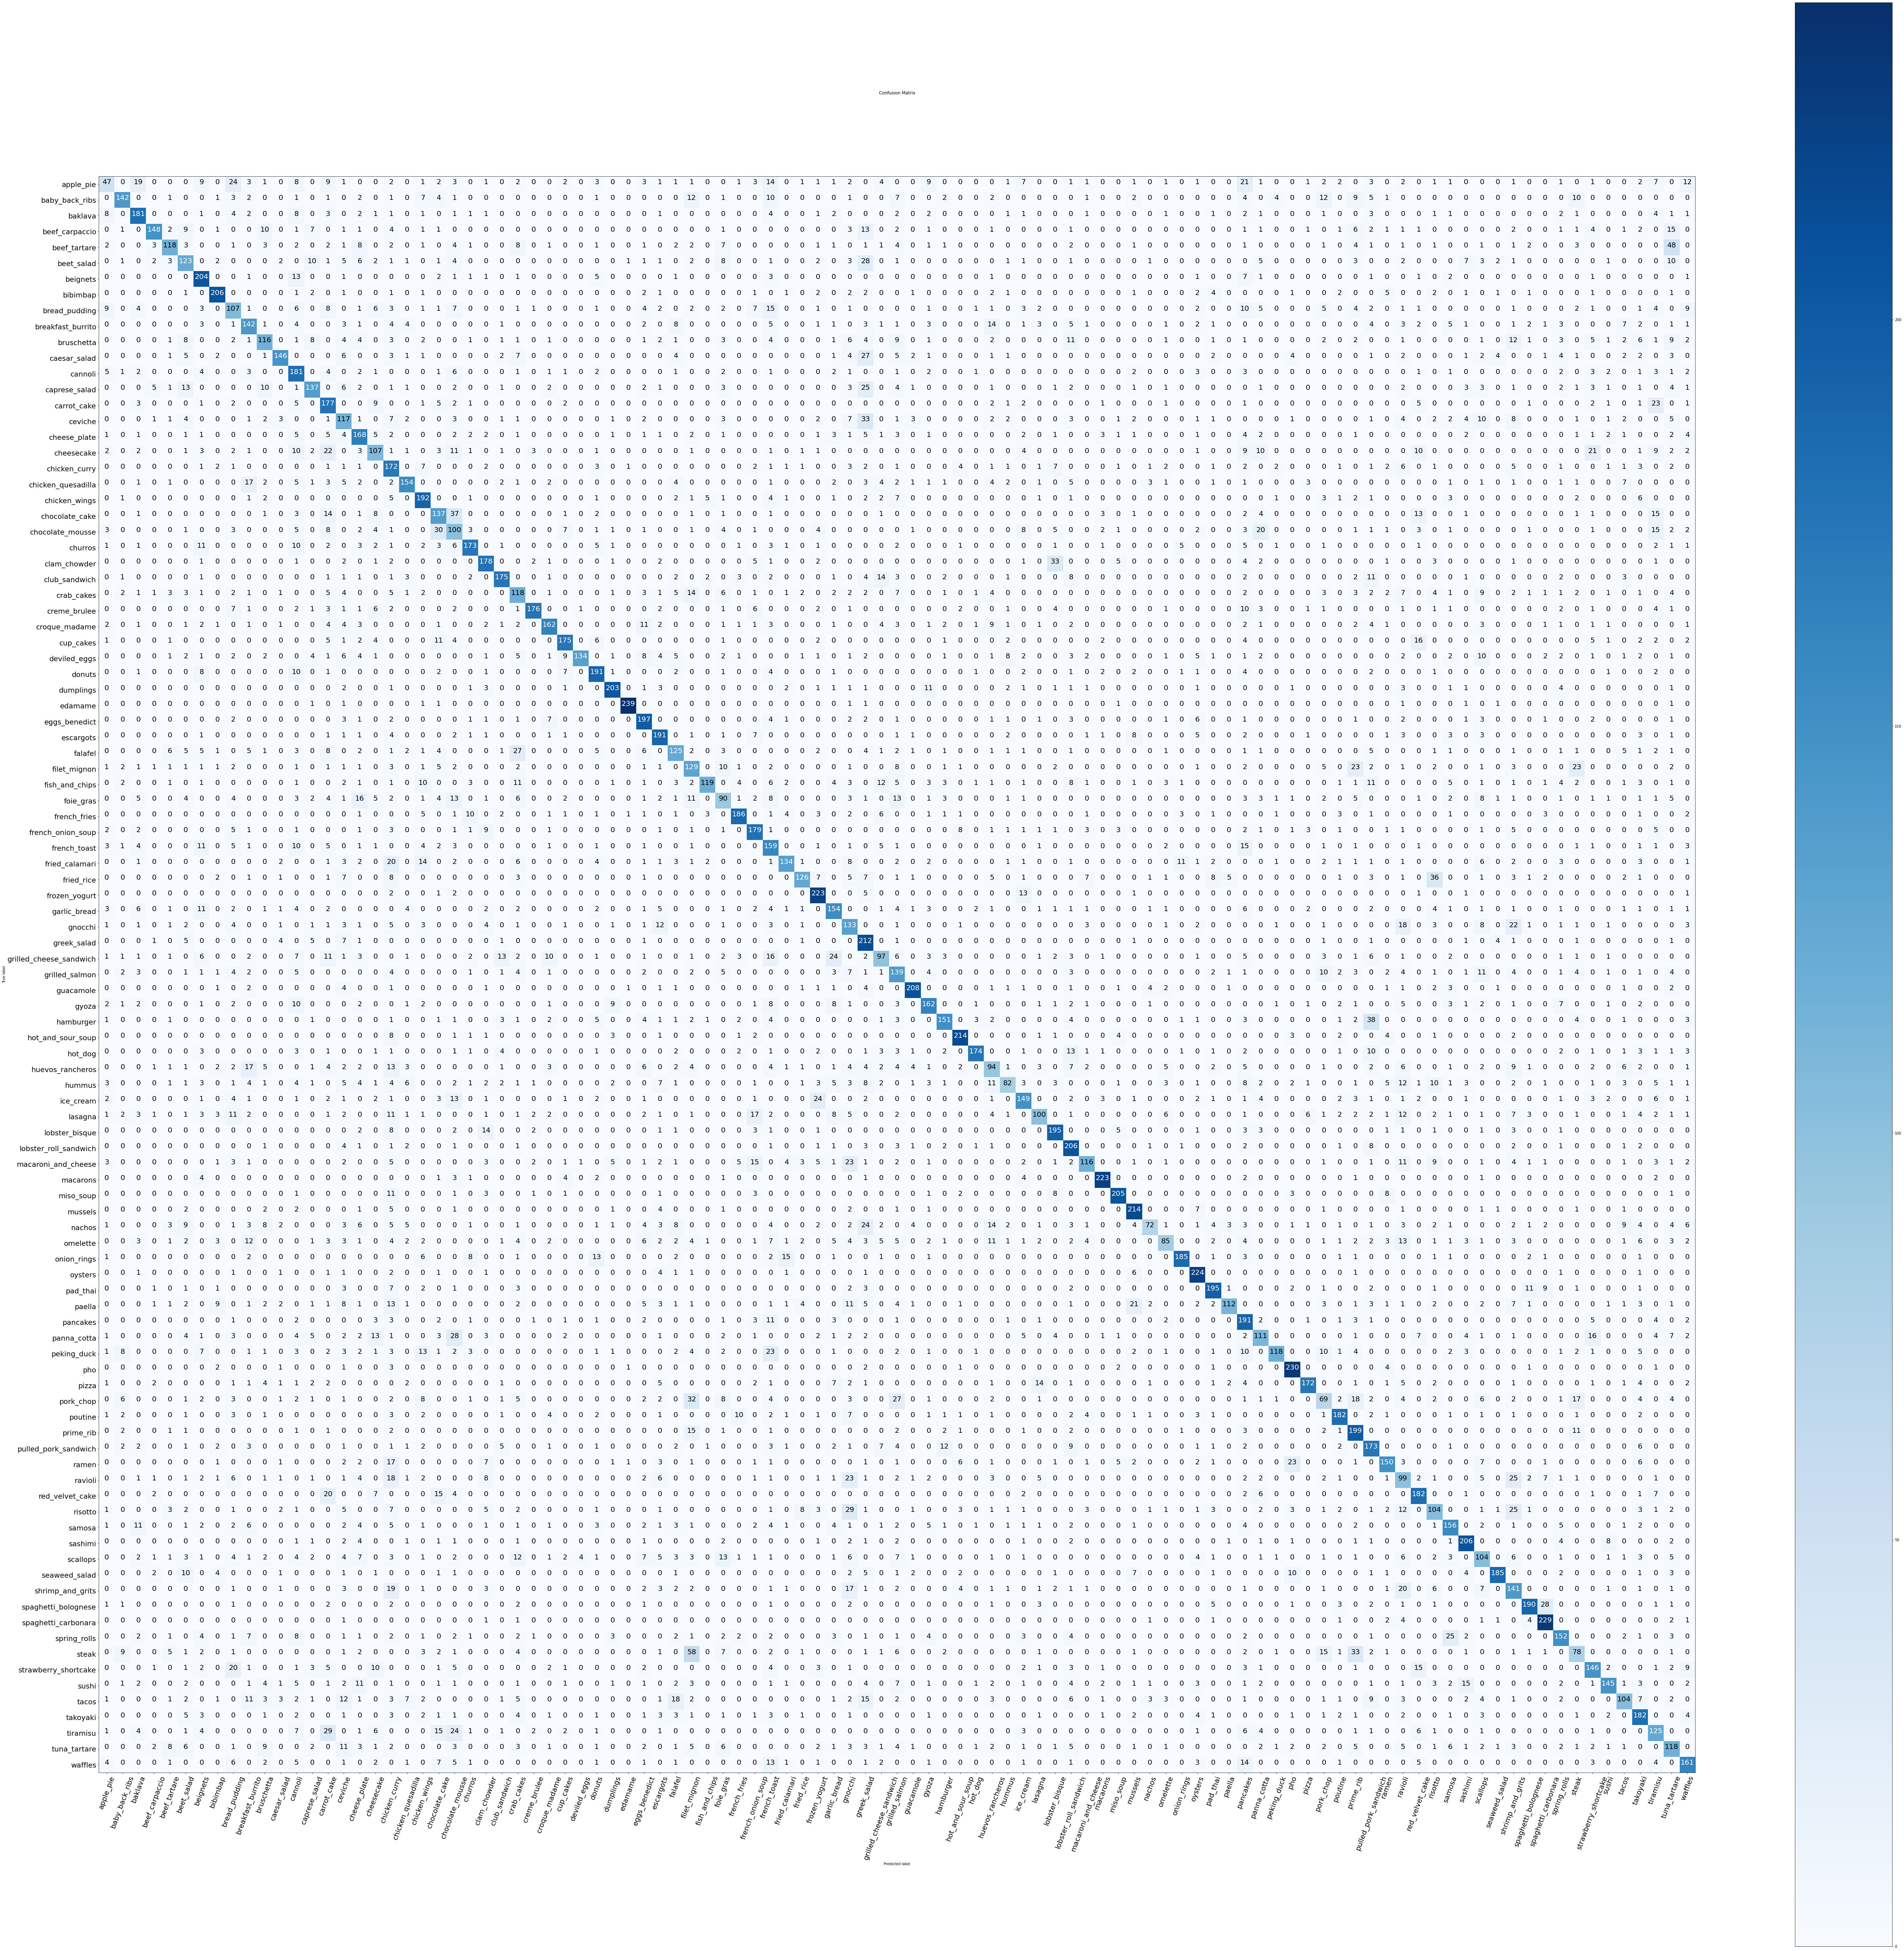

In [83]:
make_confusion_matrix(y_labels,
                      pred_classes,
                      class_names,
                      figsize=(100,100),
                      text_size=20)

CLassification report

In [84]:
from sklearn.metrics import classification_report

In [85]:
print(classification_report(y_labels,pred_classes))

              precision    recall  f1-score   support

           0       0.39      0.19      0.25       250
           1       0.74      0.57      0.64       250
           2       0.66      0.72      0.69       250
           3       0.84      0.59      0.69       250
           4       0.68      0.47      0.56       250
           5       0.48      0.49      0.49       250
           6       0.61      0.82      0.70       250
           7       0.82      0.82      0.82       250
           8       0.40      0.43      0.41       250
           9       0.53      0.57      0.55       250
          10       0.58      0.46      0.52       250
          11       0.81      0.58      0.68       250
          12       0.47      0.72      0.57       250
          13       0.67      0.55      0.60       250
          14       0.45      0.71      0.55       250
          15       0.39      0.47      0.42       250
          16       0.53      0.67      0.59       250
          17       0.51    

In [86]:
#Get dictionary of classification report
classification_report_dict = classification_report(y_labels,
                                                   pred_classes,
                                                   output_dict=True)
classification_report_dict

{'0': {'precision': 0.3949579831932773,
  'recall': 0.188,
  'f1-score': 0.25474254742547425,
  'support': 250},
 '1': {'precision': 0.743455497382199,
  'recall': 0.568,
  'f1-score': 0.6439909297052153,
  'support': 250},
 '2': {'precision': 0.6581818181818182,
  'recall': 0.724,
  'f1-score': 0.6895238095238095,
  'support': 250},
 '3': {'precision': 0.8361581920903954,
  'recall': 0.592,
  'f1-score': 0.6932084309133489,
  'support': 250},
 '4': {'precision': 0.6781609195402298,
  'recall': 0.472,
  'f1-score': 0.5566037735849056,
  'support': 250},
 '5': {'precision': 0.4823529411764706,
  'recall': 0.492,
  'f1-score': 0.48712871287128706,
  'support': 250},
 '6': {'precision': 0.6053412462908012,
  'recall': 0.816,
  'f1-score': 0.6950596252129473,
  'support': 250},
 '7': {'precision': 0.8207171314741036,
  'recall': 0.824,
  'f1-score': 0.8223552894211578,
  'support': 250},
 '8': {'precision': 0.39776951672862454,
  'recall': 0.428,
  'f1-score': 0.4123314065510597,
  'suppor

In [87]:
class_names[70]

'pad_thai'

plot of all classes F1 score

In [90]:
#create emplty dictionary
class_f1_scores={}

In [91]:
#loop thru classification dictionary items
for k,v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]


In [92]:
class_f1_scores

{'apple_pie': 0.25474254742547425,
 'baby_back_ribs': 0.6439909297052153,
 'baklava': 0.6895238095238095,
 'beef_carpaccio': 0.6932084309133489,
 'beef_tartare': 0.5566037735849056,
 'beet_salad': 0.48712871287128706,
 'beignets': 0.6950596252129473,
 'bibimbap': 0.8223552894211578,
 'bread_pudding': 0.4123314065510597,
 'breakfast_burrito': 0.5493230174081237,
 'bruschetta': 0.5155555555555554,
 'caesar_salad': 0.6790697674418605,
 'cannoli': 0.567398119122257,
 'caprese_salad': 0.6035242290748899,
 'carrot_cake': 0.5522620904836194,
 'ceviche': 0.4231464737793852,
 'cheese_plate': 0.5925925925925927,
 'cheesecake': 0.4642082429501085,
 'chicken_curry': 0.46866485013623976,
 'chicken_quesadilla': 0.6710239651416122,
 'chicken_wings': 0.6844919786096257,
 'chocolate_cake': 0.5199240986717268,
 'chocolate_mousse': 0.3454231433506045,
 'churros': 0.7238493723849372,
 'clam_chowder': 0.69126213592233,
 'club_sandwich': 0.7368421052631577,
 'crab_cakes': 0.45124282982791586,
 'creme_brulee

In [96]:
# Turn f1 scores in dataframe for visualisation
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score",ascending = False)

In [98]:
f1_scores[:10]

class_names  f1-score
33              edamame  0.965657
63             macarons  0.893788
51            guacamole  0.850716
75                  pho  0.850277
54    hot_and_sour_soup  0.847525
91  spaghetti_carbonara  0.843462
64            miso_soup  0.841889
32            dumplings  0.828571
7              bibimbap  0.822355
88        seaweed_salad  0.816777

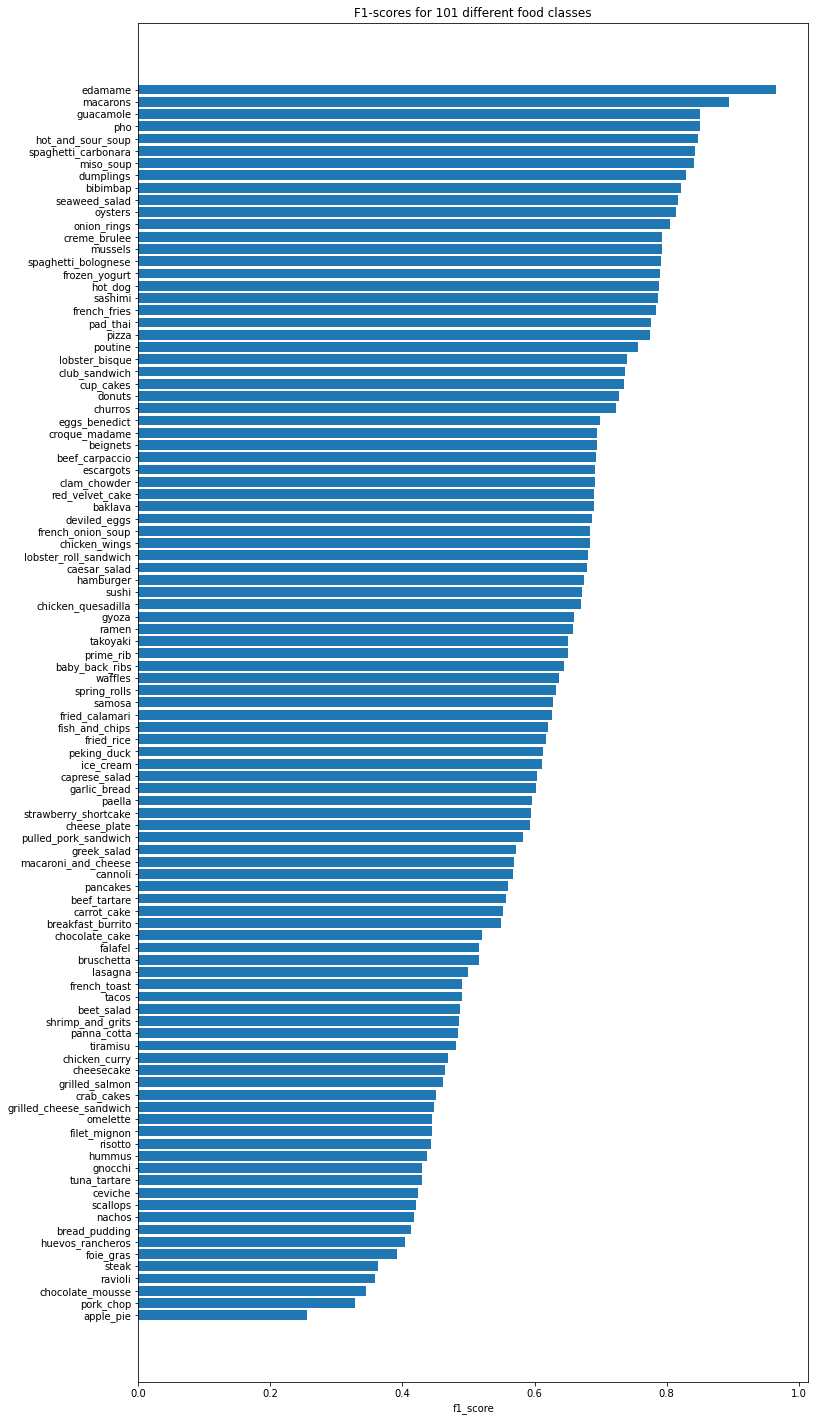

In [106]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)),f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("f1_score")
ax.set_title("F1-scores for 101 different food classes")
ax.invert_yaxis();

## Visualising predictions on custom images

create a function to load and preprocess image:
1. read image filepath using tf.io.read.file()
2. turn the image to tensor using tf.io.decode_image()
3. resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
4. scale the image all of the pixel values between 0 and 1(if necessary)

In [108]:
#create a function to load and prepare images
def load_and_prep_image(filename,img_shape=224,scale = True):
  #Read in the image
  img = tf.io.read_file(filename)

  #decode image to tensor
  img = tf.io.decode_image(img,channels=3)

  #Resize the image
  img = tf.image.resize(img, [img_shape,img_shape])

  #scale? yes/no
  if scale:
    return img/255. 
  else:
    return img

tasks:
1. load random images from test datasets.
2. make predictions on loaded image
3. plot original images along with the models predictions, prediction ptobabilities

1/1 [==============================] - 0s 26ms/step


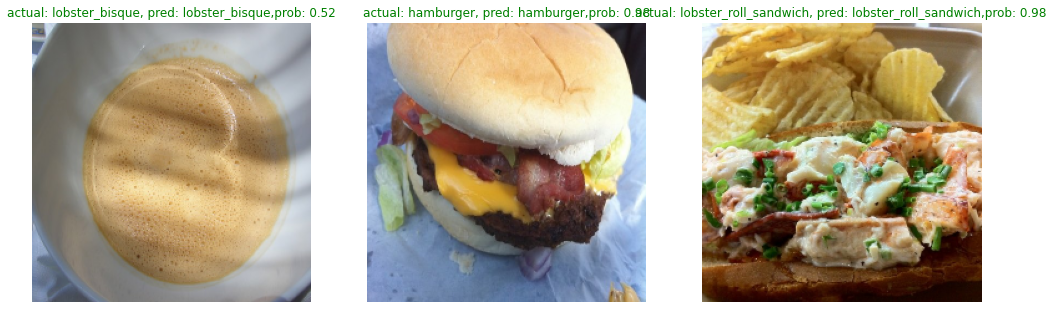

In [118]:
from tensorflow.python.ops.gen_math_ops import arg_max
#make preds on a series of random images
import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name +"/" +filename

  #load image and make predictions
  img = load_and_prep_image(filepath,scale = False)
  pred_prob = model.predict(tf.expand_dims(img,axis=0))
  pred_class = class_names[pred_prob.argmax()]
  #print(pred_prob)
  #print(pred_class)

  #Plot images
  plt.subplot(1,3,i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color ="r"
  plt.title(f"actual: {class_name}, pred: {pred_class},prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

## Finding the most wrong predictions

1. get all of the image filepaths in the test dataset
2. create a pandas dataframe of the image filepath,grounf truth labels, predicted classes, max prediction probabilities
3. use our dataframe to find all wrong probabilities
4. sort the dataframe besed on wrong predictions
5. visualise the images with the highest prediction probabilities but have wrong prediction

In [121]:
# GEt all the image filepaths in the test dataset
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle = False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [122]:
#Create dataframe of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1),
                        "y_true_classname":[class_names[i] for i in y_labels],
                        "y_pred_classname":[class_names[i] for i in pred_classes]})

In [123]:
pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      52   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0      80   
4      b'/content/101_food_classes_10_percent/test/ap...       0       8   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25247  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25248  b'/content/101_food_classes_10_percent/test/wa...     100      94   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_conf y_true_classname      y_pred_classname  
0       0.784677        apple_pie                 gyoza  
1       0.967203        apple_pie             apple_pie  
2       0.962188        apple_pie             apple_pie  
3       0.725111        apple_pie  pulled_pork_sandwich  
4       0.299486        apple_pie         bread_pudding  
...          ...              ...                   ...  
25245   0.998289          waffles               waffles  
25246   0.797948          waffles               waffles  
25247   0.911956          waffles               waffles  
25248   0.496125          waffles  strawberry_shortcake  
25249   0.953314          waffles               waffles  

[25250 rows x 6 columns]

In [124]:
#3. Find out in dataframe which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...       0      52   
1  b'/content/101_food_classes_10_percent/test/ap...       0       0   
2  b'/content/101_food_classes_10_percent/test/ap...       0       0   
3  b'/content/101_food_classes_10_percent/test/ap...       0      80   
4  b'/content/101_food_classes_10_percent/test/ap...       0       8   

   pred_conf y_true_classname      y_pred_classname  pred_correct  
0   0.784677        apple_pie                 gyoza         False  
1   0.967203        apple_pie             apple_pie          True  
2   0.962188        apple_pie             apple_pie          True  
3   0.725111        apple_pie  pulled_pork_sandwich         False  
4   0.299486        apple_pie         bread_pudding         False

In [126]:
#4. sort dataframe to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"]== False].sort_values("pred_conf",ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
17897  b'/content/101_food_classes_10_percent/test/pa...      71      65   
17855  b'/content/101_food_classes_10_percent/test/pa...      71      65   
4583   b'/content/101_food_classes_10_percent/test/ch...      18      60   
82     b'/content/101_food_classes_10_percent/test/ap...       0      45   
8776   b'/content/101_food_classes_10_percent/test/es...      35      65   
11642  b'/content/101_food_classes_10_percent/test/ga...      46      10   
18001  b'/content/101_food_classes_10_percent/test/pa...      72      67   
14631  b'/content/101_food_classes_10_percent/test/ic...      58      45   
18383  b'/content/101_food_classes_10_percent/test/pa...      73      60   
10847  b'/content/101_food_classes_10_percent/test/fr...      43      68   
143    b'/content/101_food_classes_10_percent/test/ap...       0       2   
194    b'/content/101_food_classes_10_percent/test/ap...       0       6   
5849   b'/content/101_food_classes_10_percent/test/ch...      23      68   
15359  b'/content/101_food_classes_10_percent/test/lo...      61      53   
231    b'/content/101_food_classes_10_percent/test/ap...       0     100   
8794   b'/content/101_food_classes_10_percent/test/es...      35      41   
3320   b'/content/101_food_classes_10_percent/test/ca...      13      48   
18323  b'/content/101_food_classes_10_percent/test/pa...      73      86   
14488  b'/content/101_food_classes_10_percent/test/hu...      57      35   
21856  b'/content/101_food_classes_10_percent/test/sc...      87      36   

       pred_conf       y_true_classname   y_pred_classname  pred_correct  
17897   0.999999                 paella            mussels         False  
17855   0.999998                 paella            mussels         False  
4583    0.999998          chicken_curry     lobster_bisque         False  
82      0.999996              apple_pie      frozen_yogurt         False  
8776    0.999991              escargots            mussels         False  
11642   0.999991           garlic_bread         bruschetta         False  
18001   0.999990               pancakes           omelette         False  
14631   0.999978              ice_cream      frozen_yogurt         False  
18383   0.999976            panna_cotta     lobster_bisque         False  
10847   0.999972         fried_calamari        onion_rings         False  
143     0.999960              apple_pie            baklava         False  
194     0.999959              apple_pie           beignets         False  
5849    0.999958                churros        onion_rings         False  
15359   0.999950  lobster_roll_sandwich          hamburger         False  
231     0.999950              apple_pie            waffles         False  
8794    0.999950              escargots  french_onion_soup         False  
3320    0.999924          caprese_salad        greek_salad         False  
18323   0.999921            panna_cotta            sashimi         False  
14488   0.999919                 hummus          escargots         False  
21856   0.999904               scallops            falafel         False

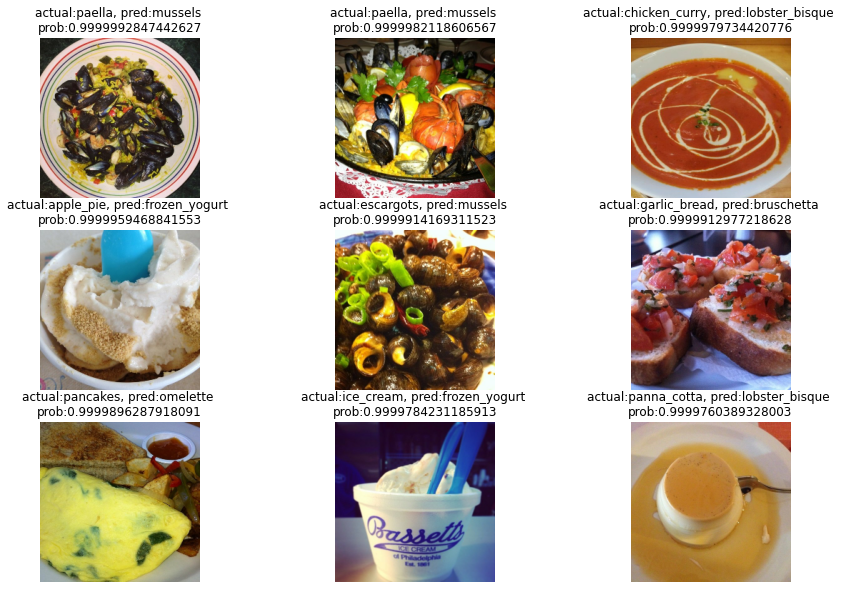

In [130]:
#5. visulaise the test data with wrong prediction but with highest probability
images_to_view = 9
start_index=0
plt.figure(figsize=(15,10))
for i,row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3,3,i+1)
  img = load_and_prep_image(row[1],scale = False)
  _,_,_,_,pred_prob,y_true_classname,y_pred_classname,_=row #getting only few parameters of each row
  plt.imshow(img/255.)
  plt.title(f"actual:{y_true_classname}, pred:{y_pred_classname} \nprob:{pred_prob}")
  plt.axis(False)

## Test big dog model on custom images

In [131]:
# Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
unzip_data("custom_food_images.zip")

--2023-01-18 06:04:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  7.85MB/s    in 1.6s    

2023-01-18 06:04:24 (7.85 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [132]:
#Get custom food images filepath
custom_food_images = ["custom_food_images/"+ img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/ramen.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/steak.jpeg']

1/1 [==============================] - 0s 51ms/step


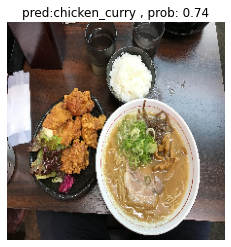

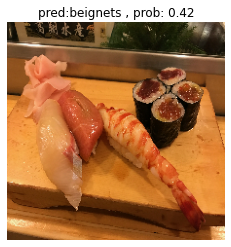

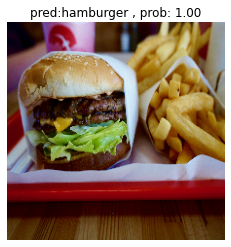

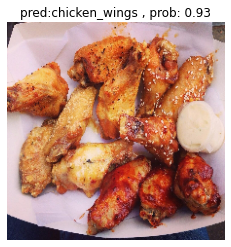

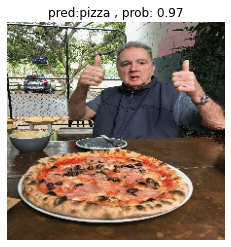

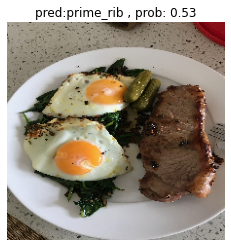

In [134]:
#Make predictions on and plot custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale = False)
  pred_prob = model.predict(tf.expand_dims(img,axis=0))
  pred_class = class_names[pred_prob.argmax()]

  #plot appropriate information
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred:{pred_class} , prob: {pred_prob.max():.2f}")
  plt.axis(False)